In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
ticker = yf.Ticker("NVDA")
print(ticker)
data = yf.download('NVDA', start='2015-01-01', end='2025-01-01')

data.head()


yfinance.Ticker object <NVDA>


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,
2015-01-02,0.483144,0.486744,0.475463,0.483144,113680000
2015-01-05,0.474983,0.484584,0.472823,0.483144,197952000
2015-01-06,0.460582,0.476183,0.460102,0.475703,197764000
2015-01-07,0.459382,0.468023,0.457942,0.463943,321808000
2015-01-08,0.476663,0.479543,0.464423,0.464663,283780000


In [3]:
ticker.info['currency']

'USD'

In [4]:
# data.index = pd.to_datetime(data.index)
# data = data.asfreq('B')

In [5]:
data = data[['Close']]
data.rename(columns={'Close': 'Price'}, inplace=True)


In [6]:
data

Price,Price
Ticker,NVDA
Date,
2015-01-02,0.483144
2015-01-05,0.474983
2015-01-06,0.460582
2015-01-07,0.459382
2015-01-08,0.476663
...,...
2024-12-24,140.220001
2024-12-26,139.929993


### Visualizing trends, seasonality, and volatility

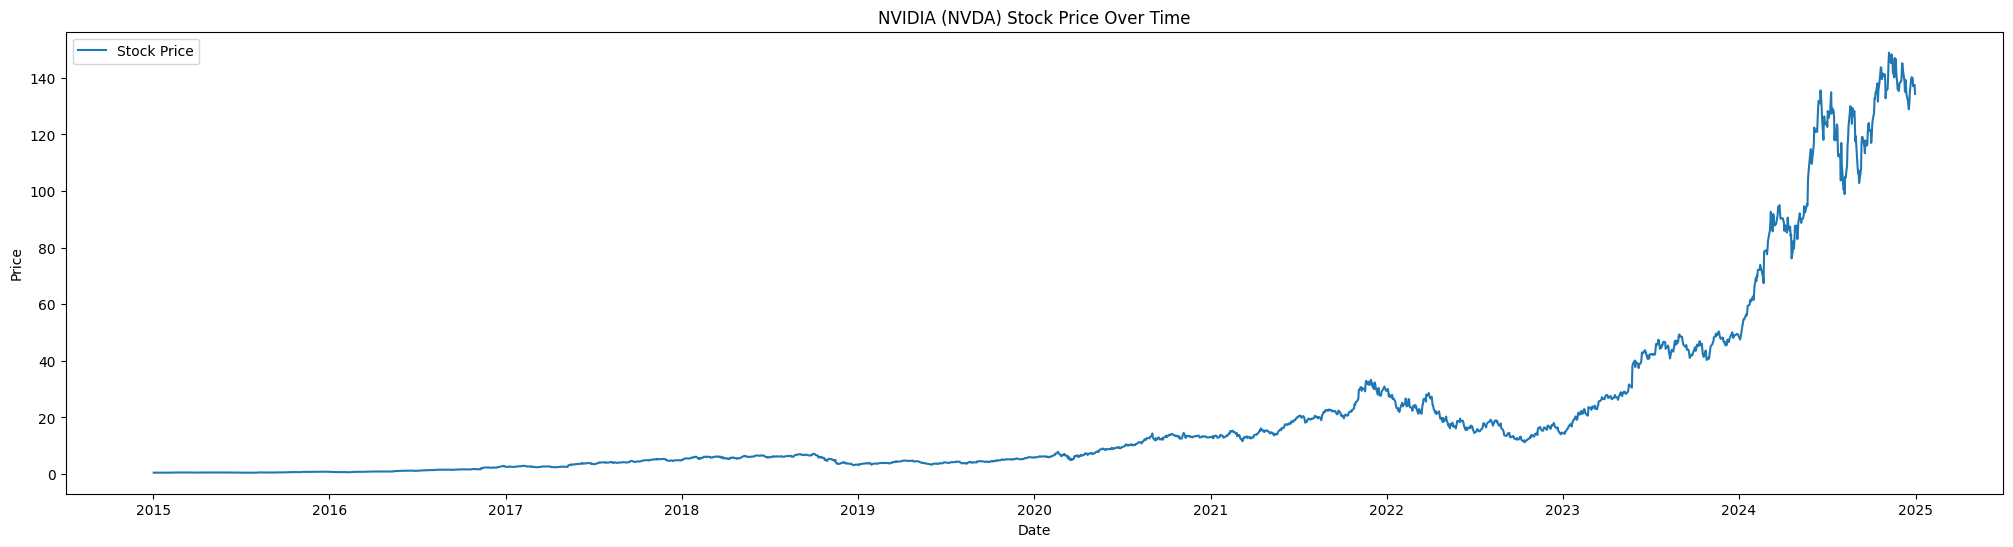

In [7]:
plt.figure(figsize=(25,6))
plt.plot(data['Price'], label='Stock Price')
plt.title('NVIDIA (NVDA) Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


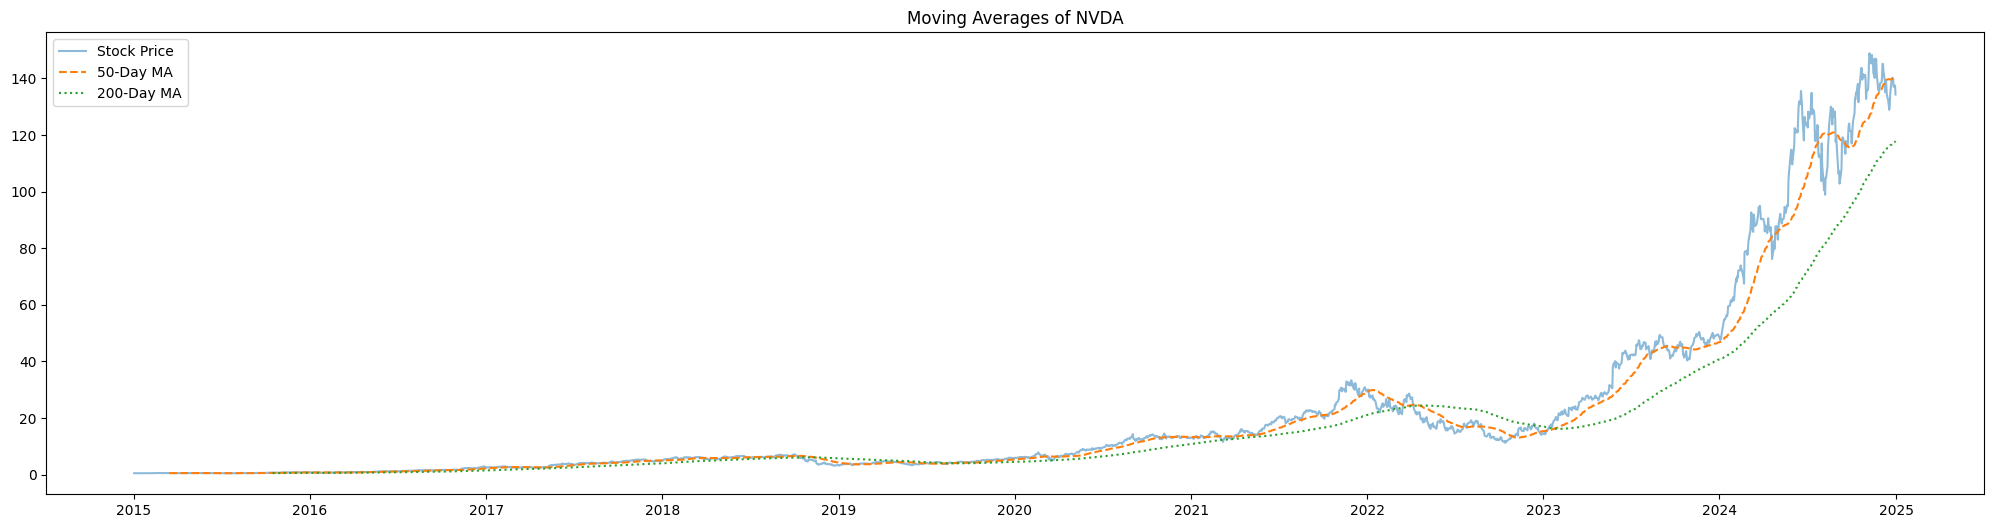

In [8]:
#trend smoothing
data_50_MA = data['Price'].rolling(window=50).mean()  # 50-day moving average
data_200_MA = data['Price'].rolling(window=200).mean()  # 200-day moving average

plt.figure(figsize=(25,6))
plt.plot(data['Price'], label='Stock Price', alpha=0.5)
plt.plot(data_50_MA, label='50-Day MA', linestyle='dashed')
plt.plot(data_200_MA, label='200-Day MA', linestyle='dotted')
plt.title('Moving Averages of NVDA')
plt.legend()
plt.show()


* upward momentum since 2023
* 50-day MA crossed above the 200-day MA (Golden Cross) -> bullish

<Figure size 640x480 with 0 Axes>

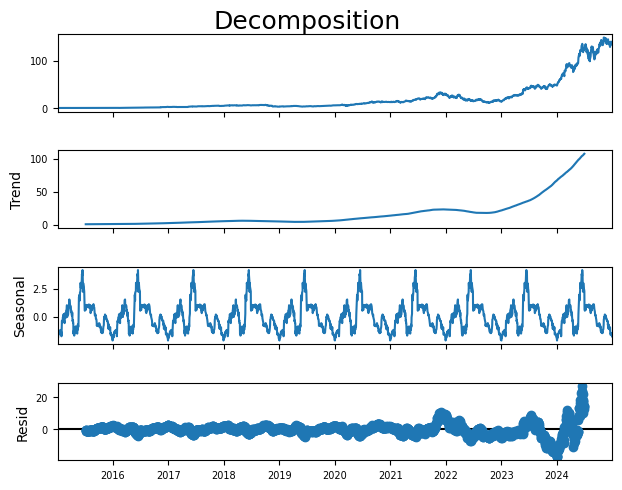

In [9]:
plt.figure()  
decomposition = seasonal_decompose(data['Price'], model='additive', period=252)

decomposition.plot()
plt.suptitle("Decomposition", fontsize=18, y=1.02)  
plt.subplots_adjust(hspace=0.5)  

for ax in plt.gcf().axes:
    ax.tick_params(axis='both', labelsize=7) 
    ax.title.set_fontsize(4)  

plt.show()


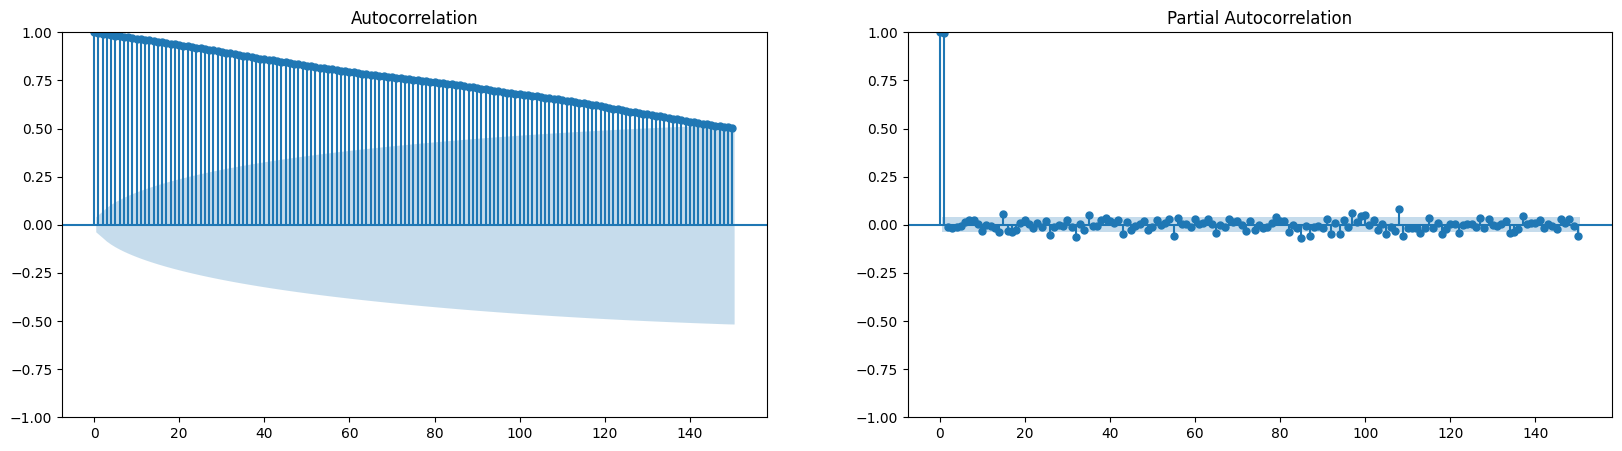

In [10]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
plot_acf(data['Price'].dropna(), lags=150, ax=ax[0])  #Autocorrelation
plot_pacf(data['Price'].dropna(), lags=150, ax=ax[1])  #Partial Autocorrelation
plt.show()

* PACF suggest p=2 (2 lags out of confidence interval)

### Stationarity tests

In [11]:
def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] <= 0.05:
        print("The series is stationary.")
    else:
        print("The series is not stationary.")

adf_test(data['Price'])

ADF Statistic: 2.769501568797666
p-value: 1.0
The series is not stationary.


In [12]:
data['Price_diff']= data['Price'].diff()

data['Price_diff']

Date
2015-01-02         NaN
2015-01-05   -0.008160
2015-01-06   -0.014401
2015-01-07   -0.001200
2015-01-08    0.017281
                ...   
2024-12-24    0.550003
2024-12-26   -0.290009
2024-12-27   -2.919998
2024-12-30    0.480011
2024-12-31   -3.200012
Name: Price_diff, Length: 2516, dtype: float64

* stationary after one differenciation (d=1)

In [13]:
adf_test(data['Price_diff'].dropna())

ADF Statistic: -9.802313237960794
p-value: 5.950090375875153e-17
The series is stationary.


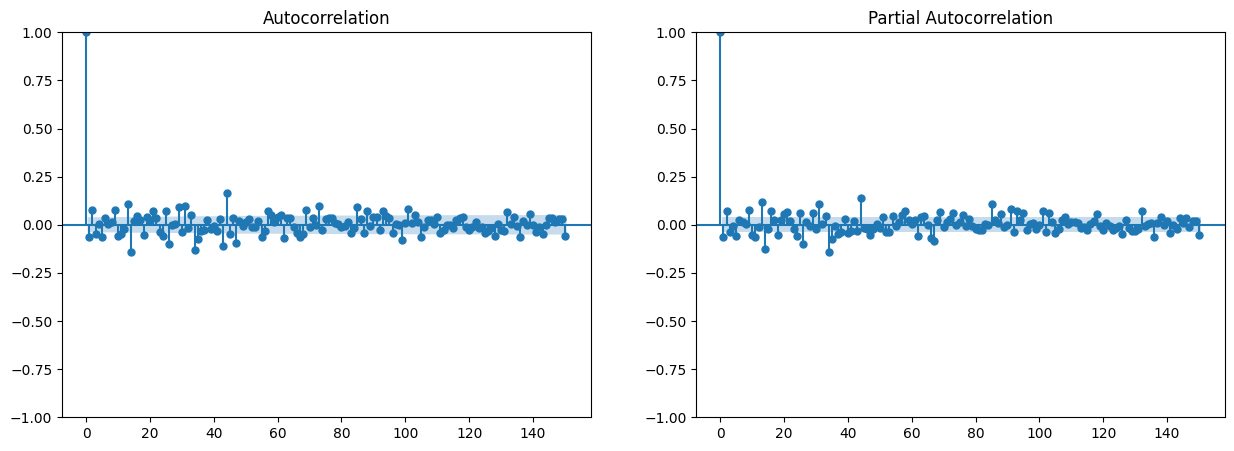

In [14]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
plot_acf(data['Price_diff'].dropna(), lags=150, ax=ax[0])  #Autocorrelation
plot_pacf(data['Price_diff'].dropna(), lags=150, ax=ax[1])  #Partial Autocorrelation
plt.show()

In [15]:
data.index = pd.to_datetime(data.index)
data = data.asfreq('B')

In [16]:
model = ARIMA(data.Price_diff, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             Price_diff   No. Observations:                 2608
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -4037.154
Date:                Thu, 06 Feb 2025   AIC                           8080.308
Time:                        17:24:47   BIC                           8097.906
Sample:                    01-02-2015   HQIC                          8086.683
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0603      0.007     -8.744      0.000      -0.074      -0.047
ma.L1         -0.9968      0.001  -1512.577      0.000      -0.998      -0.996
sigma2         1.4411      0.011    131.117      0.0

### Seasonal adjustments

In [17]:
data['Price_seasonal_diff'] = data['Price'] - data['Price'].shift(252)

In [18]:
# Seasonal differencing
adf_test(data['Price_seasonal_diff'].dropna())


ADF Statistic: 0.886901449739097
p-value: 0.9929169835659164
The series is not stationary.


In [22]:
p=2
d=1 
q=2
P=1
D=1
Q=1 
s=252 #daily data with yearly seasonality

sarima_model = SARIMAX(data['Price'], 
                    order=(p, d, q), 
                    seasonal_order=(P, D, Q, s), 
                    enforce_stationarity=False, 
                    enforce_invertibility=False)
result = model.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:             Price_diff   No. Observations:                 2608
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -4037.154
Date:                Thu, 06 Feb 2025   AIC                           8080.308
Time:                        17:32:17   BIC                           8097.906
Sample:                    01-02-2015   HQIC                          8086.683
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0603      0.007     -8.744      0.000      -0.074      -0.047
ma.L1         -0.9968      0.001  -1512.577      0.000      -0.998      -0.996
sigma2         1.4411      0.011    131.117      0.0

### Volatility Modeling